# Large-scale Anomaly Detection

**Goal:** In this tutorial, we will explore how to perform anomaly detection on a large-scale graph comprising more than 49 million edges.
We will notably see how to handle this large graph by dividing it into small sequential temporal snapshots that fit into memory, and by reducing even more their size with edge compression.

**Concepts:** `Anomaly Detection`, `Unsupervised Learning`, `Edge-based MPNN`, `Lazy Dataset`

Before digging into this tutorial, you will first need to install the following additional dependencies.

`pip install matplotlib scikit-learn`

In [1]:
import mlx.core as mx

from mlx_graphs.datasets import LANLDataset
from mlx_graphs.loaders import LANLDataLoader

## Dataset

We will be using here the `LANL` dataset. It is made up of 58 consecutive days of data gathered from
the Los Alamos National Laboratory’s internal
computer network. This version of the dataset comprises **49,341,086 auth events**
from a typical APT campaign across **17,685 Windows machines**, including
**705 malicious events**. Graphs can be constructed from authentication events,
where an edge represents an authentication action and a node represents
a machine within the network.
Each edge is associated with either a **benign** or **malicious** label, making this
dataset suitable for edge prediction/detection tasks, as well as node-based
tasks, where the machine at the origin of malicious activity can be identified.

The version of the LANL dataset proposed within mlx-graphs is already
preprocessed to only include data required to build the graphs along with
**2 default edge features** extracted from the raw dataset. Consequently,
this class will by default download a 340MB archive instead of the original
files that represent more than 7GB compressed.

The 2 provided edge features are:

* `success/failure`: 1 if the authentication succeeded, 0 if it failed
* `logon type`: identifies the type of the source user that initiated the
authentication (user -> 1, computer -> 2, anonymous -> 3)

Instantiating an instance of the LANL dataset is as easy as:

In [2]:
import os
from pathlib import Path

root_dir = os.path.join(Path(os.path.dirname(os.getcwd())).parent.parent.parent, ".mlx_graphs_data")
dataset = LANLDataset(process_original_files=False, use_gzip=True, base_dir=root_dir)

Given the large size of this dataset, loading it directly into memory can quickly become hard task. For this reason, the `LANLDataset` class is known as a `LazyDataset`. In mlx-graphs, a `LazyDataset` is a dataset that builds and loads graphs into memory only when requested.
When first instantiated, the lazy dataset downloads all required files from the Internet and stores them on disk. Typically, the large dataset is divided into multiple files that can be easily loaded independently on memory. In the case of LANL, a timestamp is by default associated to every authentication events, this allows to divide the large graph into sequential graph snapshots, lasting for a given period of time. Concretely, any dataset comprising a temporal indicator for every edge can be similarly divided into a sequence of temporal snapshots.

In the current implementation of `LANLDataset`, each file comprises 1 minute of authentication events. To build and load a graph at a particular time, indexing can be used directly on the dataset:

In [3]:
dataset[0]

GraphData(
	edge_index(shape=(2, 158), int64)
	node_features(shape=(17685, 17685), float32)
	edge_features(shape=(158, 4), float32)
	edge_labels(shape=(158,), int64)
	edge_timestamps(shape=(158,), int64))

This graph basically represents the first minute of data in the dataset.

Requesting a slice from the dataset results in merging all the graphs from this range into a single graph. For example, loading the first day of data can be done with:

In [4]:
one_day_in_minutes = 60 * 24
dataset[:one_day_in_minutes]

GraphData(
	edge_index(shape=(2, 688294), int64)
	node_features(shape=(17685, 17685), float32)
	edge_features(shape=(688294, 4), float32)
	edge_labels(shape=(688294,), int64)
	edge_timestamps(shape=(688294,), int64))

## Data Loading

To ease the consistent iteration over the entire dataset, we made available `LANLDataLoader`, a data loader dedicated to the LANL dataset.

The `batch_size` argument defines the duration of a snapshot graph, in minutes. `split` denotes the portion of the dataset to iterate on ("all" | "train" | "valid" | "test"). The `compress_edges` indicates whether to use edge compression or not.
Edge compression means that for a single requested graph, all duplicate edges between any two nodes will be compressed into a unique edge, with additional features based on the statistics of the number of compressed edges. This effectively reduces the size of the graph by eliminating duplicate edges, which may be many as the size of the graph expends. In this tutorial, we will be using edge compression.

Using edge compression, the 2 initial edge features become 6 edge features:

* `#edges`: the number of duplicate edges in the compressed edge
* `#successes`: the number of success authentications
* `#failures`: the number of failure authentications
* `#src_type_user`: the number of "user" source node type
* `#src_type_computer`: the number of "computer" source node type
* `#src_type_anonymous`: the number of "anonymous" source node type

Now that we know the theory behind the data loader, let's iterate on it and compute some statistics about the compressed graphs.

In [4]:
SNAPSHOT_DURATION = 60  # in minutes
loader = LANLDataLoader(dataset, split="all", compress_edges=True, batch_size=SNAPSHOT_DURATION, remove_self_loops=False)

Remember that the first iteration over a loader actually computes all the graph snapshots and save them on disk for a much faster loading on the subsequent iterations. The first iteration is thus pretty long as millions of edges have to be pre-processed from the raw downloaded files.

In [8]:
from mlx_graphs.utils import degree

num_edges, num_nodes, in_degrees, out_degrees = 0, 0, 0, 0
num_labels, num_snapshots_with_labels = 0, 0

for g in loader:
    num_edges += g.num_edges
    num_nodes = int(g.num_nodes)
    in_degrees += degree(g.edge_index[1]).mean().item()
    out_degrees += degree(g.edge_index[0]).mean().item()

    labels = g.edge_labels.sum()
    num_labels += labels
    
    if labels > 0:
        num_snapshots_with_labels += 1

mean_num_edges = num_edges / len(loader)
in_degrees /= len(loader)
out_degrees /= len(loader)

  0%|          | 0/1392 [00:00<?, ?it/s]

100%|██████████| 1392/1392 [10:11<00:00,  2.28it/s]


In [9]:
print(f"LANL statistics (with {SNAPSHOT_DURATION} min snapshot duration + edge compression)")
print("=" * 70)

print(f"Number of graph snapshots: {len(loader)}")
print(f"Number of nodes: {num_nodes}")
print(f"Total number of edges: {int(num_edges)}")
print(f"Avg number of edges per graph: {mean_num_edges:.2f}")
print(f"Avg node in-degree: {in_degrees:.2f}")
print(f"Avg node out-degree: {out_degrees:.2f}")

LANL statistics (with 60 min snapshot duration + edge compression)
Number of graph snapshots: 1392
Number of nodes: 17685
Total number of edges: 11116909
Avg number of edges per graph: 7986.29
Avg node in-degree: 0.61
Avg node out-degree: 0.59


As you can see below, subsequent iterations on the loader become much faster as they are directly loaded from disk.

In [10]:
for g in loader:
    pass

100%|██████████| 1392/1392 [00:01<00:00, 998.38it/s] 


## Model

Our goal is to design a GNN-based model able to differentiate between benign and malicious authentication events, with the additional constraint that we do not want to leverage any label in the training. In other terms, we're looking to perform **unsupervised edge detection**.

### GNN Encoder
Our proposed model is simple and aims to show how to merge pre-defined GNN layers like the `GCNConv`, with a custom MPNN integrating edge features.

The GCN layer can be defined as:
$$
H = \sigma \left( \tilde{D}^{-\frac{1}{2}} \tilde{A}\tilde{D}^{\frac{-1}{2}} H W \right),
$$
where $H$ denotes the node embeddings at layer $l$ and $H = X$ at the first layer, with $X$ the initial node features matrix. $\tilde{A}$ is the adjacency matrix representation of the graph with self-loops such that $\tilde{A}=A+I$, with $I$ the identity matrix of same shape as the adjacency matrix $A$. $\tilde{D}$ is the degree matrix of $\tilde{A}$, whereas $W$ represents a trainable weight matrix and $\sigma$ is the sigmoid non-linear activation function. Please note that in this context, we also utilize `edge_weights` in every call to the GCN layer. This feature is provided by the first edge feature, which is the number of duplicate edges. It has been standardized on a batch-wise basis, ensuring that the weight falls within the range of 0 to 1. Consequently, it can function as an edge weight, allowing the exchange of information between nodes in proportion to the number of duplicate edges within a compressed edge.

We also introduce a custom MPNN layer that simply integrates the edge features into the node embeddings:
$$
H_u = \sigma\left( H_u + \sum_{v \in \mathcal{N}(u)} H_u W_{\text{edge}}(E_{uv}) \right)
$$
where $E_{uv}$ represents the feature vector of the edge $(u,v)$, $\mathcal{N}(u)$ denotes the neighbors of node $u$ and $W_{\text{edge}}$ is a weight matrix to project the edge features into a dimension that matches the shape of node embeddings.

Finally, edge embeddings can be derived from the node embeddings:
$$
H_{uv} = W_{proj}\left( H_u + H_v\right), \quad (u, v) \in \mathcal{E}
$$

### Decoder

We want here to train the edge embeddings in an unsupervised manner. We propose an encoder/decoder architecture, where we compress the edge embeddings into a low-dimensional space, and decode this compressed representation to preserve the structural and integrated features captured by the encoder. Formally, the reconstructed estimation of an edge embedding $H_{uv}$ can be defined as:
$$
\hat{H}_{uv} = \text{AE}(H_{uv})
$$
where $\text{AE}$ denotes an Autoencoder model.

Trained on benign edges, this encoder will learn to generate low reconstruction errors for seen benign edges, aiming to produce high reconstruction errors for anomalous edges during testing.
The reconstruction error between the edge embedding $H_{uv}$ and the reconstructed edge embedding $\hat{H}_{uv}$ is calculated with the MSE loss: 

$$
e_{uv} = (H_{uv} - \hat{H}_{uv})^2
$$

In [5]:
import mlx.nn as nn
from mlx_graphs.nn import GCNConv, MessagePassing

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim=None):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim if out_dim is None else out_dim)

    def __call__(self, x):
        encoded = nn.relu(self.encoder(x))
        decoded = nn.sigmoid(self.decoder(encoded))
        return decoded

class EdgeGCN(MessagePassing):
    """
    A simple GNN model that with 2 GCN layers and a custom MPNN layer integrating
    edge features with sum aggregation.
    """
    def __init__(
        self,
        node_features_dim: int,
        hidden_features_dim: int,
        out_features_dim: int,
        edge_features_dim: int,
        num_layers: int = 2,
        dropout: float = 0.25,
        bias: bool = True,
    ):
        super().__init__(aggr='add')

        layer_sizes = (
            [node_features_dim]
            + [hidden_features_dim] * (num_layers - 1)
            + [out_features_dim]
        )
        self.gcn_layers = [
            GCNConv(in_dim, out_features_dim, bias, add_self_loops=True)
            for in_dim, out_features_dim in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.dropout = nn.Dropout(p=dropout)
        self.W_edge = nn.Linear(edge_features_dim, out_features_dim)
        self.W_proj = nn.Linear(out_features_dim, out_features_dim)

        self.AE = Autoencoder(out_features_dim, out_features_dim // 2)

    def __call__(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_weights: mx.array,
        edge_features: mx.array,
    ) -> mx.array:
        """Calculates the overall loss for training"""
        # First computes the reconstruction error of every edges (i.e. e_{uv}, for all (u, v))
        H = self._forward(edge_index, node_features, edge_weights, edge_features)
        
        # Computes reconstruction estimation \hat{H}_{uv}
        H_hat = self.AE(H)

        # Computes the MSE loss for all edges, with mean reduction, (i.e. mean of all e_{uv})
        loss = nn.losses.mse_loss(H_hat, H, reduction="mean")
        return loss

    def inference(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_weights: mx.array,
        edge_features: mx.array,
    ) -> mx.array:
        """Calculates edge anomaly scores"""
        # First computes the reconstruction error of every edges (i.e. e_{uv}, for all (u, v))
        H = self._forward(edge_index, node_features, edge_weights, edge_features)
        
        # Computes reconstruction estimation \hat{H}_{uv}
        H_hat = self.AE(H)
        
        # Computes MSE loss for each edge (all e_{uv} without reduction)
        # This will serve as the anomalous score
        recon_scores = nn.losses.mse_loss(H_hat, H, reduction="none")
        recon_scores = mx.sum(recon_scores, axis=1)
        return recon_scores

    def _forward(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_weights: mx.array,
        edge_features: mx.array,
    ):
        """Simply computes edge embeddings"""
        # Computes node embeddings with GCN layers
        for layer in self.gcn_layers[:-1]:
            H = nn.tanh(layer(edge_index, node_features, edge_weights=edge_weights))
            H = self.dropout(H)
        H = self.gcn_layers[-1](edge_index, H, edge_weights=edge_weights)

        # Integrates edge features with the custom MPNN defined in `message()`
        # the sum aggregation happens with `super().__init__(aggr='add')`
        aggreg = self.propagate(edge_index, H, message_kwargs={"edge_features": edge_features})
        H = nn.tanh(H + aggreg)

        # Computes edge embeddings with sum of the two end nodes
        H = self.W_proj(H[edge_index[0, :]] + H[edge_index[1, :]])
        return H


    def message(self, src_features, dst_features, edge_features):
        """Computes edge messages to integrate edge feature information"""
        # Applies a linear transformation to match the node and edge embedding shapes
        edge_features = self.W_edge(edge_features)

        # Integrates transformed edge features into the node emeddings
        return src_features * edge_features

In [6]:
NUM_NODES = 17685
HIDDEN_SIZE = 64
OUT_SIZE = 32
EDGE_FEATURES_DIM = 13
NUM_LAYERS = 2
LR = 0.0001

model = EdgeGCN(
    node_features_dim=NUM_NODES,
    hidden_features_dim=HIDDEN_SIZE,
    out_features_dim=OUT_SIZE,
    edge_features_dim=EDGE_FEATURES_DIM,
    num_layers=NUM_LAYERS,
    bias=True,
)
mx.eval(model.parameters())

### Training

We will be using the `Adam` optimizer provided in MLX, and we also define a `forward_fn` function that is passed to `value_and_grad` to compute gradients.

In [7]:
import mlx.optimizers as optim

def forward_fn(model, edge_index, node_features, edge_weights, edge_features, labels, inference=False):
    if inference:
        return model.inference(edge_index, node_features, edge_weights, edge_features)
    return model(edge_index, node_features, edge_weights, edge_features)

optimizer = optim.Adam(learning_rate=LR)
loss_and_grad_fn = nn.value_and_grad(model, forward_fn)

The `LANLDataLoader` comes with pre-defined time ranges to split the dataset into train/eval/test sets. We'll use those ranges as an example.
The train and eval loaders contain benign-only graphs built from benign authentication activity in the LANL network, whereas the test set comprises some malicious events from APT campaigns.

In [8]:
train_loader = LANLDataLoader(dataset, split="train", compress_edges=True, batch_size=SNAPSHOT_DURATION, tqdm_bar=True)
eval_loader = LANLDataLoader(dataset, split="valid", compress_edges=True, batch_size=SNAPSHOT_DURATION, tqdm_bar=True)
test_loader = LANLDataLoader(dataset, split="test", compress_edges=True, batch_size=SNAPSHOT_DURATION, tqdm_bar=True)

Now let's define a dedicated function to either train, eval or test the model for a single epoch.

In [9]:
def train():
    avg_loss = 0.
    for graph in train_loader:
        edge_weights = graph.edge_features[:, 0]
        (loss), grads = loss_and_grad_fn(
            model, graph.edge_index, graph.node_features, edge_weights, graph.edge_features, graph.edge_labels
        )
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)
        avg_loss += loss.item()
    
    return avg_loss / len(train_loader)

def eval():
    avg_loss = 0.
    for graph in eval_loader:
        edge_weights = graph.edge_features[:, 0]
        loss = forward_fn(
            model, graph.edge_index, graph.node_features, edge_weights, graph.edge_features, graph.edge_labels
        )
        avg_loss += loss.item()
    
    return avg_loss / len(eval_loader)

During testing, the model is utilized in inference mode to calculate an anomalousness score for each edge. For demonstration purposes, we use a supervised approach to determine an optimal threshold value that distinguishes between benign and malicious edges. However, fully unsupervised methods can also be applied in this context.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score, average_precision_score as ap_score

def test():
    all_edge_losses, all_edge_labels = [], []

    for i, graph in enumerate(test_loader):
        edge_weights = graph.edge_features[:, 0]
        edge_losses = forward_fn(
            model, graph.edge_index, graph.node_features, edge_weights, graph.edge_features, graph.edge_labels, inference=True
        )
        all_edge_losses.extend(edge_losses.tolist())
        all_edge_labels.extend(graph.edge_labels.tolist())
   
    def find_best_threshold_supervised_auc(all_edge_losses, all_edge_labels):
        all_edge_labels, all_edge_losses = np.array(all_edge_labels), np.array(all_edge_losses)
        fpr, tpr, thresholds = roc_curve(all_edge_labels, all_edge_losses)
        roc_auc = auc(fpr, tpr)

        # Filter out the points where TPR is less than 0.8
        valid_indices = np.where(tpr >= 0.8)[0]
        fpr_valid = fpr[valid_indices]
        thresholds_valid = thresholds[valid_indices]

        # Find the threshold corresponding to the lowest FPR among valid points
        optimal_idx = np.argmin(fpr_valid)
        optimal_threshold = thresholds_valid[optimal_idx]
        
        return optimal_threshold

    def compute_metrics(ys, y_hats, all_edge_losses):
        ys, y_hats, all_edge_losses = np.array(ys), np.array(y_hats), np.array(all_edge_losses)
        attack_idxs = (ys == 1).nonzero()[0]

        overall_acc = (ys == y_hats).mean()
        precision, recall, _, _ = precision_recall_fscore_support(ys, y_hats, average='binary')

        tp  = y_hats[ys == 1].sum()
        fp  = y_hats[ys == 0].sum()
        tpr = y_hats[ys == 1].mean()
        fpr = y_hats[ys == 0].mean()

        len_positives = len((ys == 1).nonzero()[0])
        len_negatives = len((ys == 0).nonzero()[0])

        try:
            auc_score = roc_auc_score(ys, all_edge_losses)
            auc_fpr, auc_tpr, _ = roc_curve(ys, all_edge_losses)
        except: auc_score = float('nan'); auc_fpr = float('nan'); auc_tpr = float('nan')

        try:
            ap = ap_score(ys, all_edge_losses)
        except: ap = float('nan')

        print(f"Detected {tp} anomalies / {len(attack_idxs)} anomalous edges ({(tp/len(attack_idxs))*100:.5f}%).")
        print(f"TPR: {tpr:.3f} | FPR: {fpr:.6f} | Overall acc: {overall_acc:.6f} | AP: {ap:.3f} | AUC: {auc_score:.3f} | recall: {recall:.3f} | precision: {precision:.3f}")
        print(f"TP: {tp}/{len_positives} | FP: {fp}/{len_negatives}\n")

        return auc_fpr, auc_tpr, auc_score
    
    best_threshold = find_best_threshold_supervised_auc(all_edge_losses, all_edge_labels)
    y_hat = mx.where(mx.array(all_edge_losses) > best_threshold, 1, 0)

    return compute_metrics(all_edge_labels, y_hat, all_edge_losses)

Let's now run the training loop and measure some metrics such as AUC, FPR and TPR.

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.71it/s]


Epoch   0 | Train loss: 0.2147 | Val loss: 0.0533


100%|██████████| 1351/1351 [05:01<00:00,  4.48it/s]


Detected 398 anomalies / 498 anomalous edges (79.91968%).
TPR: 0.799 | FPR: 0.007513 | Overall acc: 0.992478 | AP: 0.004 | AUC: 0.965 | recall: 0.799 | precision: 0.005
TP: 398/498 | FP: 81202/10808560



100%|██████████| 3/3 [00:00<00:00, 18.10it/s]


Epoch   1 | Train loss: 0.0256 | Val loss: 0.0092


100%|██████████| 1351/1351 [01:16<00:00, 17.62it/s]


Detected 398 anomalies / 498 anomalous edges (79.91968%).
TPR: 0.799 | FPR: 0.007078 | Overall acc: 0.992913 | AP: 0.004 | AUC: 0.981 | recall: 0.799 | precision: 0.005
TP: 398/498 | FP: 76503/10808560



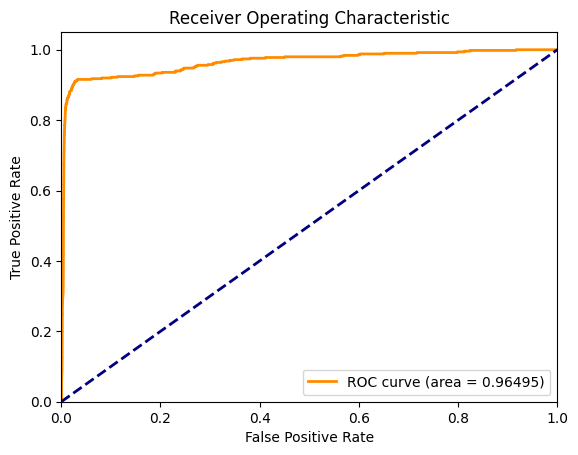

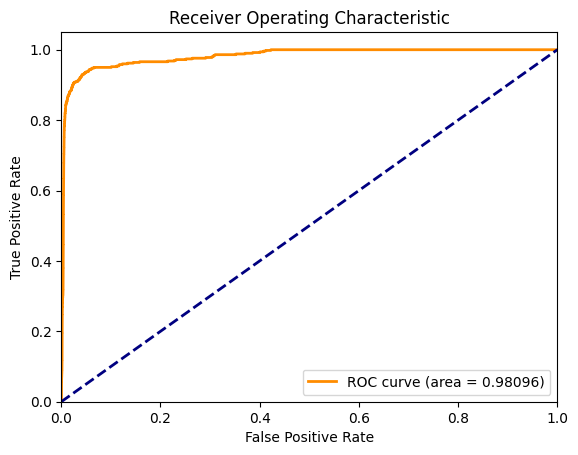

In [11]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):

    train_loss = train()
    eval_loss = eval()

    print(f"Epoch {epoch:>3} | Train loss: {train_loss:.4f} | Val loss: {eval_loss:.4f}")
    
    auc_fpr, auc_tpr, auc_score = test()

    plt.figure()
    plt.plot(auc_fpr, auc_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.5f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Save the figure
    plt.savefig('roc_curve.png')

## Conclusion

In this tutorial, we have seen how to perform anomaly detection on large graphs with the LANL dataset.
This example provides a simple implementation to deal with the LANL dataset. We refer to the following papers for those seeking to reach state-of-the-art results with GNNs and temporal methods on this dataset. 

[1] Euler: Detecting Network Lateral Movement via Scalable Temporal Link Prediction

[2] Understanding and Bridging the Gap Between Unsupervised Network Representation Learning and Security Analytics